# Exploring the Gender differences in Programming using Python

## Or a very short tutorial into agent based modeling in Mesa

Based on the comments that I have heard in the last year, it seems that more and more people are pushing for the cultural interpretation of gender and gender differences. So there is a lot of talk about how the culture is pushing these 'stereotypical' gender roles and they 'oppress' the people that are not,... I don't know, it seems that these days everybody is 'oppressed'.

And then they come up with a lot of explanations. I think my favourite explanation (as it the ones that I found the funniest) of why there are gender differences in different professions come from sociology department. Especially, if they have a feminism included in their department name or in their title. If we take programming jobs, one of the reasons that Wynn and Correll found that alienated women were references to the movies, that they may not have seen (Article: [Puncturing the pipeline: Do technology companies alienate women in recruiting sessions?](https://doi.org/10.1177/0306312718756766)).

So today, I am going to be trying to show with a simple simulation, why these explanations may not tell the whole story. At the same time, this can also serve as a very simple tutorial to agent-based modelling with python library Mesa.

### Imports

First, we need to import the libraries that are going to be used in this tutorial/argumentation. Let us start with imports connected with the agent-based modelling, that is going to be used.

In [1]:
from mesa.time import RandomActivation
from mesa import Agent, Model
import random

Next, we are going to import the libraries, that are going to be used for calculating some statistics, connected with the modelling of the question (I generally do statistics in R, so I apologize, if there is a better way of doing it in Python).

In [2]:
from sklearn.preprocessing import scale
import scipy.stats as stats
import statistics
import numpy

And last one, import that will allow us some visualization. 

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

### Modeling Differences in Skills

There are generally differences in levels of different skills between genders, though the distributions have a lot of overlap. One very representative test of these differences is PISA, where they test a relatively large sample (for social sciences) of students for each country. When comparing the mathematical and reading scores, the males generally score higher in mathematics, and women generally score higher in reading. 

There are a couple of interesting things, that these results can show. For example, the countries that have no difference in mathematical skills also have the higher differences in reading skills (Article: [Sex Differences in Mathematics and Reading Achievement Are Inversely Related: Within- and Across-Nation Assessment of 10 Years of PISA Data](https://doi.org/10.1371/journal.pone.0057988)). And I am sure there are many others.

The scores are usually standardized to a mean of 500 and a standard deviation of 100 for everybody who took the test. These are also the scores that we used here. I just took the PISA scores from the OCED site: [http://www.pisa.oecd.org](http://www.pisa.oecd.org). The data that I have chosen was for Slovenia, for the year 2015, in reading and mathematics score. 

All I did then, was to save them in different variables. 

In [4]:
MathematicalFemaleMean = 508
MathematicalFemaleSd = 86
MathematicalMaleMean = 512
MathematicalMaleSd = 89
ReadingFemaleMean = 528
ReadingFemaleSd = 86
ReadingMaleMean = 484
ReadingMaleSd = 92

Now, to give you an example of how these distributions look, I have created the graph here. As you can see from the graph, the distribution for mathematical skills is basically the same, while this is not true for the reading skills. There the women are a bit better, but as you can see, there is still a far bit of overlap. 

Text(0.5, 1.0, 'Differences in Reading Ability')

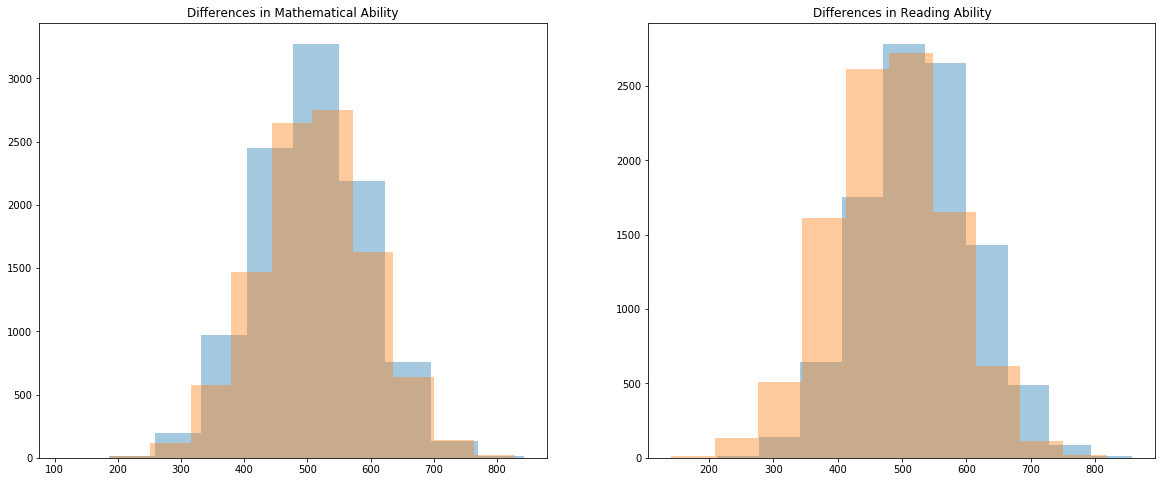

In [5]:
f = plt.figure(figsize=(20,8))
plot1 = f.add_subplot(1, 2, 1)
plot1.hist([random.gauss(MathematicalFemaleMean, MathematicalFemaleSd) for i in range(10000)], alpha=.4)
plot1.hist([random.gauss(MathematicalMaleMean, MathematicalMaleSd) for i in range(10000)], alpha=.4)
plot1.set_title("Differences in Mathematical Ability")
plot2 = f.add_subplot(1, 2, 2)
plot2.hist([random.gauss(ReadingFemaleMean, ReadingFemaleSd) for i in range(10000)], alpha=.4)
plot2.hist([random.gauss(ReadingMaleMean, ReadingMaleSd) for i in range(10000)], alpha=.4)
plot2.set_title("Differences in Reading Ability")

What is the next step, is to start making the model, that we are going to be using for researching these differences. 

What needs to be done first, is to create the agents, that we can make them do stuff so we can find out something new about it. Each of these agents has some attributes and have some ability to do something. 

Let us start by making an agent with some attributes. In our case, the agent is a human, with a gender, a specific level of the mathematical skills and a specific level of the reading (read: verbal) skills. We are also going to be giving him a very limited memory. He will be able to keep track of the work it will do.

So each of our "humans" will be randomly assigned the gender. It will only pick between two option, and I am not sorry for ignoring a certain minority here. Then, based on the gender, it will be also assigned the level of each skill, sampled from the distribution. And on the end, we will imprint on their memories, that they have done no work yet. 

In [6]:
class Human(Agent):
    
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.gender = random.choice(["female", "male"])
        if self.gender == "female":
            self.reading = random.gauss(ReadingFemaleMean, ReadingFemaleSd)
            self.mathematical = random.gauss(MathematicalFemaleMean, MathematicalFemaleSd)
        elif self.gender == "male":
            self.reading = random.gauss(ReadingMaleMean, ReadingMaleSd)
            self.mathematical = random.gauss(MathematicalMaleMean, MathematicalMaleSd)
        self.work = 0

But this people will also need to make a choice of what kind of work they will be doing. Here, I am going to be borrowing from the person starting the modern day economics, David Ricardo and his comparable advantage. What his theory of comparable advantage says is, that if people trade based on the opportunity costs, they are better off.

So in our case, this is based on the skills. Let us take a very simple example. We have two people, are have the same skills in reading. But one person is better in mathematics than the other. And let us say that that person is twice as good. These two people can still trade, as in time, since the first person can create twice as much of mathematical value in the time they need to create one unit of reading value. So the first person can trade a fraction of his mathematical work (between the work output of the second person and his whole output) for that one unit of reading, and there is still some left over for him. And the second person gets more mathematical value, then they would get by working on it themselves. 

I have decided on the simple case, and the end decision is binary. One person does the unit of mathematical work or the unit of reading work or nothing. There are no fractions. 

Here it is also seen how I decided to keep track of the work. If a person does mathematical work, then they add one to their memory of work. If they do the reading work, then they subtract one from their memory of work. And if they do no work, then there is no change. So, if they end up with a positive number on the end, then they did more mathematical work, and if they end up with a negative number, then they did more reading work. This is what we will check on the end. 

In [7]:
class Human(Agent):
    
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.gender = random.choice(["female", "male"])
        if self.gender == "female":
            self.reading = random.gauss(ReadingFemaleMean, ReadingFemaleSd)
            self.mathematical = random.gauss(MathematicalFemaleMean, MathematicalFemaleSd)
        elif self.gender == "male":
            self.reading = random.gauss(ReadingMaleMean, ReadingMaleSd)
            self.mathematical = random.gauss(MathematicalMaleMean, MathematicalMaleSd)
        self.work = 0
        
    def skill(self, mathematical1, reading1, mathematical2, reading2):
        ratio1 = mathematical1/reading1
        ratio2 = mathematical2/reading2
        #First person doing math work
        if ratio1 > ratio2:
            return 1
        #First person doing verbal work
        elif ratio1 < ratio2:
            return -1
        #Nobody does any work
        else:
            return 0

Sure, our "human" can now make a decision, but we still need to tell him to make a decision. This is why each agent usually has the function step, where we tell him what to do in this step. 

In our case, we are going to tell our "human" to randomly grab a random person. Then compare their skills and decide, if they want to do any trading. If they want to, then they do the work and say goodbye. So there is going to be no tracking of the network of people. Which is something, that would also be interesting, but we are not going to tackle here. 

In [8]:
class Human(Agent):
    
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.gender = random.choice(["female", "male"])
        if self.gender == "female":
            self.reading = random.gauss(ReadingFemaleMean, ReadingFemaleSd)
            self.mathematical = random.gauss(MathematicalFemaleMean, MathematicalFemaleSd)
        elif self.gender == "male":
            self.reading = random.gauss(ReadingMaleMean, ReadingMaleSd)
            self.mathematical = random.gauss(MathematicalMaleMean, MathematicalMaleSd)
        self.work = 0
        
    def step(self):
        other_agent = random.choice(self.model.schedule.agents)
        work_done = self.skill(self.mathematical, self.reading, other_agent.mathematical, other_agent.reading)
        self.work = self.work + work_done
        other_agent.work = other_agent.work + (work_done * (-1))
        
    def skill(self, mathematical1, reading1, mathematical2, reading2):
        ratio1 = mathematical1/reading1
        ratio2 = mathematical2/reading2
        #First person doing math work
        if ratio1 > ratio2:
            return 1
        #First person doing verbal work
        elif ratio1 < ratio2:
            return -1
        #Nobody does any work
        else:
            return 0

So, now that we have out "humans" that we have created, we now need to put them in a "world" where they can act. Or, as more commonly known as the model. So what this does is save the number of "humans" that we create. We also track them (thankfully the GDPR does not apply to agents we create so we can track them however we want). Then we tell the model, that in each step, go randomly through all the "humans" and execute their step function. 

In [9]:
class ExchangeModel(Model):
    
    def __init__(self, N):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        for i in range(self.num_agents):
            a = Human(i, self)
            self.schedule.add(a)
            
    def step(self):
        self.schedule.step()

So now the last step, before we can actually run the model. We need to tell the model, how many "humans" to create and how many times we will force them to go through action. In our case, we create 100 "humans" and make them go through 100 cycles, which on average means 200 exchanges. 

In [10]:
model = ExchangeModel(100)
for i in range(100):
    model.step()

Now let us see some statistics. First, we will get the values of work for all out created humans, based on gender. 

In [11]:
women_work = [a.work for a in model.schedule.agents if a.gender == "female"]
men_work = [a.work for a in model.schedule.agents if a.gender == "male"]

And now we can calculate the ratio of people of each gender, that did more mathematical work (because I would count programming and more mathematical type of work). 

In [12]:
ratio_of_women_in_STEM = len([woman for woman in women_work if woman > 0])/len(women_work)

In [13]:
ratio_of_men_in_STEM = len([men for men in men_work if men > 0])/len(men_work)

In [14]:
(ratio_of_women_in_STEM, ratio_of_men_in_STEM)

(0.423728813559322, 0.5853658536585366)

As you can see, there are already noticeable gender differences, even though seeing the graphs before, we would not think this. 

In order to make sure, we would not need to write this much, we are going to create a function. Because we are going to be running quite a couple more simulations. All I did was to put the above calculations into one function.

In [15]:
def get_ratios(schedule):
    women_work = [a.work for a in schedule if a.gender == "female"]
    men_work = [a.work for a in schedule if a.gender == "male"]
    ratio_of_women_in_STEM = len([woman for woman in women_work if woman > 0])/len(women_work)
    ratio_of_men_in_STEM = len([men for men in men_work if men > 0])/len(men_work)
    return ratio_of_women_in_STEM, ratio_of_men_in_STEM

Which now allows us to see, if this was a fluke. Maybe we just got that one run, that was a bit more extreme. So let us now repeat the simulations multiple times. 

All I did this time, was to run the same simulation 100 times. And then I saved the results of each run for the ratio of "humans" choosing the mathematical work for each gender. 

In [16]:
all_rations_women = []
all_rations_men = []

In [17]:
for j in range(100):
    model = ExchangeModel(100)
    for i in range(100):
        model.step()
    ratios = get_ratios(model.schedule.agents)
    all_rations_women.append(ratios[0])
    all_rations_men.append(ratios[1])

Let us first see the mean ratio for each gender. As you can see, the ratios are still quite different. 

In [18]:
statistics.mean(all_rations_women)

0.42062172336144804

In [19]:
statistics.mean(all_rations_men)

0.5779696834173701

Let us now also plot the distribution of ratios for each gender. I used very similar code to the one for the upper graph.

As you can see from the graph, the distributions are a lot less overlapping than the ones only based on skills. Men are a lot more likely to simply choose the mathematical work (at least from economical perspective). 

Text(0.5, 1.0, 'Ratio of mathematical work based on gender')

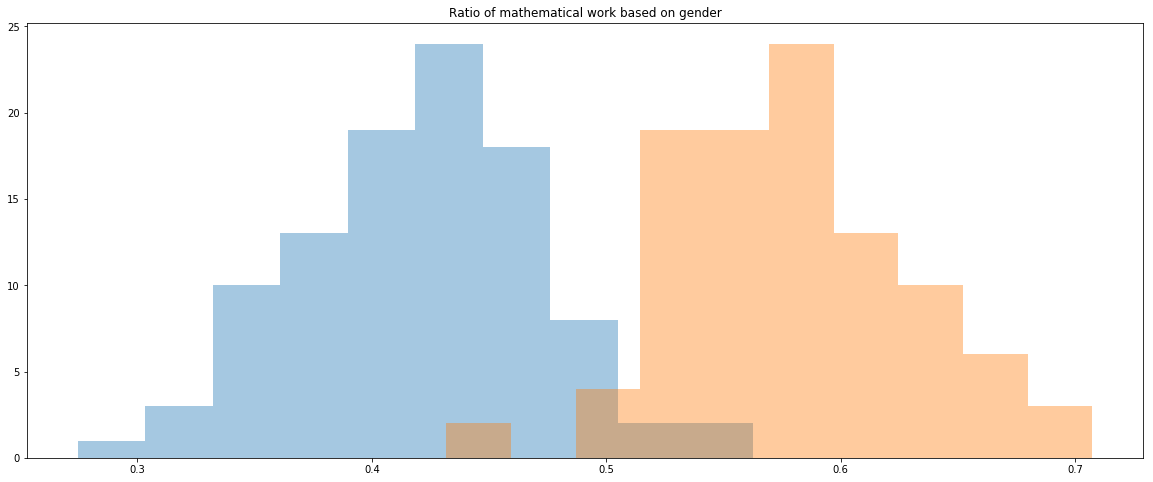

In [20]:
f = plt.figure(figsize=(20,8))
plot1 = f.add_subplot(1, 1, 1)
plot1.hist(all_rations_women, alpha=.4)
plot1.hist(all_rations_men, alpha=.4)
plot1.set_title("Ratio of mathematical work based on gender")

### Modeling differences in Interest

Not only there are skills differences, but they are also differences in interest. One of the measurements for the differences in interests is the empathizing-systemizing difference. What this tells us is, how interested is a person is systems vs. how interested is a person is humans and art (or everything else that can be approached in a non-systemized way - like based on emotions or intuition). It is much more about how the world is categorized or organized, but these also show quite interesting differences in what people are interested in. For example, in children, the men are more interested in toy cars and the women in dolls (on average). And some of this differences can be covered by these measurements. 

It is not directly connected to the skills. Though there are some (for me) very unintuitive results as well. For example, systemizing have no effect on mathematical skills in children, but empathizing does. The higher the empathizing score, the lower the mathematical skill. (Article: [The Empathizing-Systemizing Theory, Social Abilities, and Mathematical Achievement in Children](https://doi.org/10.1038/srep23011))

This theory is a lot of times mentioned in a case of autism studies, where the autistic people are considered people with extreme-male brains, or people with very high systemizing, and lower empathizing scores. 

Here, I did not (so far) found any Slovenian data, so the data here is from the US. (Article: [Measuring Empathizing and Systemizing with a Large US Sample](https://doi.org/10.1371/journal.pone.0031661))

In [21]:
EmpathizingFemaleMean = 3.089
EmpathizingFemaleSd = 0.297
EmpathizingMaleMean = 2.897
EmpathizingMaleSd = 0.309
SystemizingFemaleMean = 2.582
SystemizingFemaleSd = 0.374
SystemizingMaleMean = 2.757
SystemizingMaleSd = 0.376

So now let us look at the distribution of gender differences here. As you are going to see, the gender differences are again very much overlapping. Even though there is again a noticeable shift in the empathizing graph. 

The graphs were again created very similarly to the first example. 

Text(0.5, 1.0, 'Differences in Empathizing')

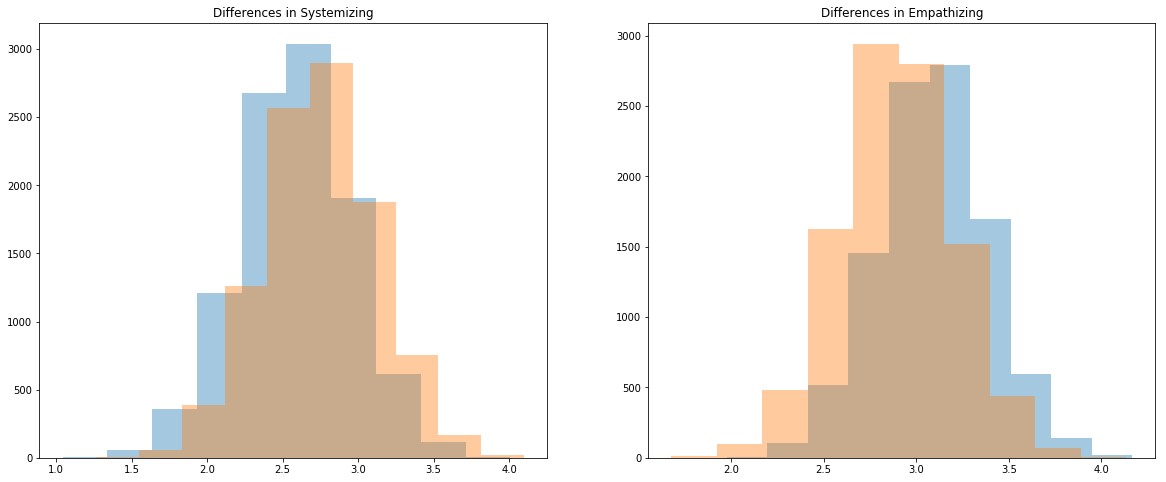

In [22]:
f = plt.figure(figsize=(20,8))
plot1 = f.add_subplot(1, 2, 1)
plot1.hist([random.gauss(SystemizingFemaleMean, SystemizingFemaleSd) for i in range(10000)], alpha=.4)
plot1.hist([random.gauss(SystemizingMaleMean, SystemizingMaleSd) for i in range(10000)], alpha=.4)
plot1.set_title("Differences in Systemizing")
plot2 = f.add_subplot(1, 2, 2)
plot2.hist([random.gauss(EmpathizingFemaleMean, EmpathizingFemaleSd) for i in range(10000)], alpha=.4)
plot2.hist([random.gauss(EmpathizingMaleMean, EmpathizingMaleSd) for i in range(10000)], alpha=.4)
plot2.set_title("Differences in Empathizing")

There is just one problem with the data. Since it was measured with different surveys for different construct (empathizing vs. systemizing) we can get the gender difference, but not the relative strength of each interest in one person. So I am going to use standardization, in order to try to correct for this. 

What I am going to do first, it that I am going to simulate the data for each of the concept and for each gender. My samples are going to be 10.000 "people" big. 

In [23]:
EmpathizingMaleDist = [random.gauss(EmpathizingMaleMean, EmpathizingMaleSd) for i in range(10000)]
EmpathizingFemaleDist = [random.gauss(EmpathizingFemaleMean, EmpathizingFemaleSd) for i in range(10000)]
SystemizingMaleDist = [random.gauss(SystemizingMaleMean, SystemizingMaleSd) for i in range(10000)]
SystemizingFemaleDist = [random.gauss(SystemizingFemaleMean, SystemizingFemaleSd) for i in range(10000)]

Next, I am going to be standardizing each concept, putting both genders together. And then I am going to divide results by gender again. 

In [24]:
SystemizingDist = list(scale(SystemizingMaleDist + SystemizingFemaleDist))
EmpathizingDist = list(scale(EmpathizingMaleDist + EmpathizingFemaleDist))
EmpathizingMaleDist = EmpathizingDist[:10000]
EmpathizingFemaleDist = EmpathizingDist[10000:]
SystemizingMaleDist = SystemizingDist[:10000]
SystemizingFemaleDist = SystemizingDist[10000:]

And we come up with distribution, that is very similar to the one, made from the original data. 

Text(0.5, 1.0, 'Differences in Empathizing')

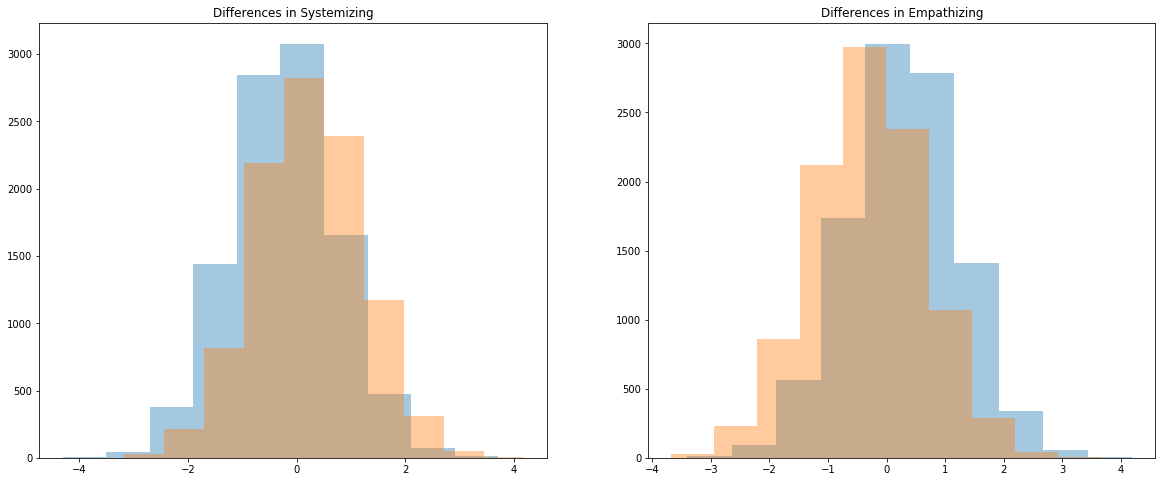

In [25]:
f = plt.figure(figsize=(20,8))
plot1 = f.add_subplot(1, 2, 1)
plot1.hist(SystemizingFemaleDist, alpha=.4)
plot1.hist(SystemizingMaleDist, alpha=.4)
plot1.set_title("Differences in Systemizing")
plot2 = f.add_subplot(1, 2, 2)
plot2.hist(EmpathizingFemaleDist, alpha=.4)
plot2.hist(EmpathizingMaleDist, alpha=.4)
plot2.set_title("Differences in Empathizing")

So now we can calculate the values we are going to be using from this new distributions. All that happens here is a calculation of mean and standard deviation for each distribution we generated. 

In [26]:
EmpathizingFemaleMean = statistics.mean(EmpathizingFemaleDist)
EmpathizingFemaleSd = statistics.stdev(EmpathizingFemaleDist)
EmpathizingMaleMean = statistics.mean(EmpathizingMaleDist)
EmpathizingMaleSd = statistics.stdev(EmpathizingMaleDist)
SystemizingFemaleMean = statistics.mean(SystemizingFemaleDist)
SystemizingFemaleSd = statistics.stdev(SystemizingFemaleDist)
SystemizingMaleMean = statistics.mean(SystemizingMaleDist)
SystemizingMaleSd = statistics.stdev(SystemizingMaleDist)

Now we can print these values to check them.

In [27]:
print(EmpathizingFemaleMean, EmpathizingFemaleSd)
print(EmpathizingMaleMean, EmpathizingMaleSd)
print(SystemizingFemaleMean, SystemizingFemaleSd)
print(SystemizingMaleMean, SystemizingMaleSd)

0.2987862382044011 0.9408303560293565
-0.29878623820440137 0.9677158531646203
-0.2286852604595836 0.9680245030268926
0.22868526045958226 0.979042503879627


Now we are going again to engineering out "humans". As before, we first define the attributes. It is very similar to the first model, except that now instead of skills, we are going to have interest.

In [28]:
class Human(Agent):
    
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.gender = random.choice(["female", "male"])
        if self.gender == "female":
            self.systemizing = random.gauss(SystemizingFemaleMean, SystemizingFemaleSd)
            self.emphatizing = random.gauss(EmpathizingFemaleMean, EmpathizingFemaleSd)
        elif self.gender == "male":
            self.systemizing = random.gauss(SystemizingMaleMean, SystemizingMaleSd)
            self.emphatizing = random.gauss(EmpathizingMaleMean, EmpathizingMaleSd)
        self.work = 0

Next, we need to define his decision process. In this case, I don't think the economics are going to be as helpful. Instead, we are going to make the decision simple. If one agent is more interested in one type of work, and the other agent is more interested in another type of work, then they will trade. If not, then they will not trade. So I imagine that there is going to be a lot less completed trades here, but it is again another thing that we are not going to check. 

In [29]:
class Human(Agent):
    
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.gender = random.choice(["female", "male"])
        if self.gender == "female":
            self.systemizing = random.gauss(SystemizingFemaleMean, SystemizingFemaleSd)
            self.emphatizing = random.gauss(EmpathizingFemaleMean, EmpathizingFemaleSd)
        elif self.gender == "male":
            self.systemizing = random.gauss(SystemizingMaleMean, SystemizingMaleSd)
            self.emphatizing = random.gauss(EmpathizingMaleMean, EmpathizingMaleSd)
        self.work = 0
        
    def interest(self, systemizing1, emphatizing1, systemizing2, emphatizing2):
        #First person doing math work
        if systemizing1 > emphatizing1 and systemizing2 < emphatizing2:
            return 1
        #First person doing verbal work
        elif systemizing1 < emphatizing1 and systemizing2 > emphatizing2:
            return -1
        #Nobody does any work
        else:
            return 0

Like any agent, this one also needs a step function, which tells it what to do each time. The step function is very similar to the first example, the only thing we will do it change which function it uses for decision.

In [30]:
class Human(Agent):
    
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.gender = random.choice(["female", "male"])
        if self.gender == "female":
            self.systemizing = random.gauss(SystemizingFemaleMean, SystemizingFemaleSd)
            self.emphatizing = random.gauss(EmpathizingFemaleMean, EmpathizingFemaleSd)
        elif self.gender == "male":
            self.systemizing = random.gauss(SystemizingMaleMean, SystemizingMaleSd)
            self.emphatizing = random.gauss(EmpathizingMaleMean, EmpathizingMaleSd)
        self.work = 0
        
    def step(self):
        other_agent = random.choice(self.model.schedule.agents)
        work_done = self.interest(self.systemizing, self.emphatizing, other_agent.systemizing, other_agent.emphatizing)
        self.work = self.work + work_done
        other_agent.work = other_agent.work + (work_done * (-1))
        
    def interest(self, systemizing1, emphatizing1, systemizing2, emphatizing2):
        #First person doing math work
        if systemizing1 > emphatizing1 and systemizing2 < emphatizing2:
            return 1
        #First person doing verbal work
        elif systemizing1 < emphatizing1 and systemizing2 > emphatizing2:
            return -1
        #Nobody does any work
        else:
            return 0

We can use exactly the same model that we defined for the first model. So we are not going to repeat it here. 

So now we will again run the model for 100 times with 100 "humans" doing 100 cycles and having on average 200 trade opportunities. 

In [31]:
all_rations_women = []
all_rations_men = []

In [32]:
for j in range(100):
    model = ExchangeModel(100)
    for i in range(100):
        model.step()
    ratios = get_ratios(model.schedule.agents)
    all_rations_women.append(ratios[0])
    all_rations_men.append(ratios[1])

And again, just like before, we can see the mean ratio for each gender.

In [33]:
statistics.mean(all_rations_women)

0.3331739044778136

In [34]:
statistics.mean(all_rations_men)

0.6430994827527692

And we can check the distribution for each gender. As you can see here, the things are even more extreme, than in the previous example. Here the distributions are no longer overlapping. 

Text(0.5, 1.0, 'Ratio of mathematical work based on gender')

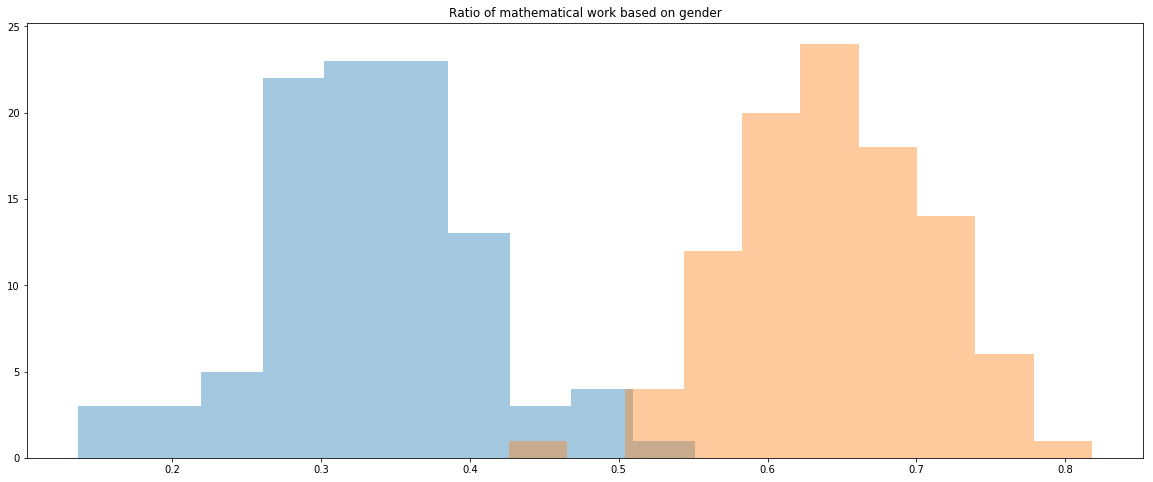

In [35]:
f = plt.figure(figsize=(20,8))
plot1 = f.add_subplot(1, 1, 1)
plot1.hist(all_rations_women, alpha=.4)
plot1.hist(all_rations_men, alpha=.4)
plot1.set_title("Ratio of mathematical work based on gender")

### Combining the models

In the last model, that we are going to do here, we are going to combine the previous two model and added the effect of the habits. 

The first thing that we are going to do, is to simply combine the attributes, that we have defined in the previous two models. We are also going to simply copy the two decision-making rules, that we had already defined. 

In [36]:
class Human(Agent):
    
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.gender = random.choice(["female", "male"])
        if self.gender == "female":
            self.reading = random.gauss(ReadingFemaleMean, ReadingFemaleSd)
            self.mathematical = random.gauss(MathematicalFemaleMean, MathematicalFemaleSd)
            self.systemizing = random.gauss(SystemizingFemaleMean, SystemizingFemaleSd)
            self.emphatizing = random.gauss(EmpathizingFemaleMean, EmpathizingFemaleSd)
        elif self.gender == "male":
            self.reading = random.gauss(ReadingMaleMean, ReadingMaleSd)
            self.mathematical = random.gauss(MathematicalMaleMean, MathematicalMaleSd)
            self.systemizing = random.gauss(SystemizingMaleMean, SystemizingMaleSd)
            self.emphatizing = random.gauss(EmpathizingMaleMean, EmpathizingMaleSd)
        self.work = 0
    
    def skill(self, mathematical1, reading1, mathematical2, reading2):
        ratio1 = mathematical1/reading1
        ratio2 = mathematical2/reading2
        #First person doing math work
        if ratio1 > ratio2:
            return 1
        #First person doing verbal work
        elif ratio1 < ratio2:
            return -1
        #Nobody does any work
        else:
            return 0
        
    def interest(self, systemizing1, emphatizing1, systemizing2, emphatizing2):
        #First person doing math work
        if systemizing1 > emphatizing1 and systemizing2 < emphatizing2:
            return 1
        #First person doing verbal work
        elif systemizing1 < emphatizing1 and systemizing2 > emphatizing2:
            return -1
        #Nobody does any work
        else:
            return 0

Next, we are going to be adding the decision-making rule based on the habits. So people are going to be more likely to do the work, that they have done more frequently in the past. So if the person has done more mathematical work in the past, then they will be more willing to do more mathematical work. And if they did more verbal work in the past, they will be more willing to do more verbal work going forward.

In [37]:
class Human(Agent):
    
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.gender = random.choice(["female", "male"])
        if self.gender == "female":
            self.reading = random.gauss(ReadingFemaleMean, ReadingFemaleSd)
            self.mathematical = random.gauss(MathematicalFemaleMean, MathematicalFemaleSd)
            self.systemizing = random.gauss(SystemizingFemaleMean, SystemizingFemaleSd)
            self.emphatizing = random.gauss(EmpathizingFemaleMean, EmpathizingFemaleSd)
        elif self.gender == "male":
            self.reading = random.gauss(ReadingMaleMean, ReadingMaleSd)
            self.mathematical = random.gauss(MathematicalMaleMean, MathematicalMaleSd)
            self.systemizing = random.gauss(SystemizingMaleMean, SystemizingMaleSd)
            self.emphatizing = random.gauss(EmpathizingMaleMean, EmpathizingMaleSd)
        self.work = 0
    
    def skill(self, mathematical1, reading1, mathematical2, reading2):
        ratio1 = mathematical1/reading1
        ratio2 = mathematical2/reading2
        #First person doing math work
        if ratio1 > ratio2:
            return 1
        #First person doing verbal work
        elif ratio1 < ratio2:
            return -1
        #Nobody does any work
        else:
            return 0
        
    def interest(self, systemizing1, emphatizing1, systemizing2, emphatizing2):
        #First person doing math work
        if systemizing1 > emphatizing1 and systemizing2 < emphatizing2:
            return 1
        #First person doing verbal work
        elif systemizing1 < emphatizing1 and systemizing2 > emphatizing2:
            return -1
        #Nobody does any work
        else:
            return 0
        
    def habits(self, work1, work2):
        # if they are both indiferent, they don't work
        if work1 == work2 == 0:
            return 0
        #First person doing math work
        if work1 >= 0 and work2 <= 0:
            return 1
        #First person doing verbal work
        elif work1 <= 0 and work1 >= 0:
            return -1
        #Nobody does any work
        else:
            return 0

So for the last part, we now need to create a step function, which will combine these decision-making rules. In decision-making theory, the non-weighted decisions are more robust and produce better results in most situations. So this is what will be used in the model. Our "humans" will check all the decision-making rules, and see in which way are they leaning. Then they will make a decision that will have more decision-making rules pointing in that direction. The non-trade decisions will be ignored. If the same amount of decision will point in both direction, then no trade will happen. 

In [38]:
class Human(Agent):
    
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.gender = random.choice(["female", "male"])
        if self.gender == "female":
            self.reading = random.gauss(ReadingFemaleMean, ReadingFemaleSd)
            self.mathematical = random.gauss(MathematicalFemaleMean, MathematicalFemaleSd)
            self.systemizing = random.gauss(SystemizingFemaleMean, SystemizingFemaleSd)
            self.emphatizing = random.gauss(EmpathizingFemaleMean, EmpathizingFemaleSd)
        elif self.gender == "male":
            self.reading = random.gauss(ReadingMaleMean, ReadingMaleSd)
            self.mathematical = random.gauss(MathematicalMaleMean, MathematicalMaleSd)
            self.systemizing = random.gauss(SystemizingMaleMean, SystemizingMaleSd)
            self.emphatizing = random.gauss(EmpathizingMaleMean, EmpathizingMaleSd)
        self.work = 0
        
    def step(self):
        other_agent = random.choice(self.model.schedule.agents)
        work_done_skills = self.skill(self.mathematical, self.reading, other_agent.mathematical, other_agent.reading)
        work_done_interest = self.interest(self.systemizing, self.emphatizing, other_agent.systemizing, other_agent.emphatizing)
        work_done_habit = self.habit(self.work, other_agent.work)
        work_done_sum = sum([work_done_skills, work_done_interest, work_done_habit])
        if work_done_sum > 0:
            work_done = 1
        elif work_done_sum < 0:
            work_done = -1
        else:
            work_done = 0
        self.work = self.work + work_done
        other_agent.work = other_agent.work + (work_done * (-1))
    
    def skill(self, mathematical1, reading1, mathematical2, reading2):
        ratio1 = mathematical1/reading1
        ratio2 = mathematical2/reading2
        #First person doing math work
        if ratio1 > ratio2:
            return 1
        #First person doing verbal work
        elif ratio1 < ratio2:
            return -1
        #Nobody does any work
        else:
            return 0
        
    def interest(self, systemizing1, emphatizing1, systemizing2, emphatizing2):
        #First person doing math work
        if systemizing1 > emphatizing1 and systemizing2 < emphatizing2:
            return 1
        #First person doing verbal work
        elif systemizing1 < emphatizing1 and systemizing2 > emphatizing2:
            return -1
        #Nobody does any work
        else:
            return 0
        
    def habit(self, work1, work2):
        # if they are both indiferent, they don't work
        if work1 == work2 == 0:
            return 0
        #First person doing math work
        if work1 >= 0 and work2 <= 0:
            return 1
        #First person doing verbal work
        elif work1 <= 0 and work1 >= 0:
            return -1
        #Nobody does any work
        else:
            return 0

Now the only thing left is to run the simulations again, the same way we did in both of the previous cases. 

In [39]:
all_rations_women = []
all_rations_men = []

In [40]:
for j in range(100):
    model = ExchangeModel(100)
    for i in range(100):
        model.step()
    ratios = get_ratios(model.schedule.agents)
    all_rations_women.append(ratios[0])
    all_rations_men.append(ratios[1])

Now, just like before, let us check the mean of distributions of ratios. 

In [41]:
statistics.mean(all_rations_women)

0.38707279528104044

In [42]:
statistics.mean(all_rations_men)

0.6140420879258315

And let us check, how much are the distributions overlapping. Again, it seems that the distributions are not overlapping a lot. 

Text(0.5, 1.0, 'Ratio of mathematical work based on gender')

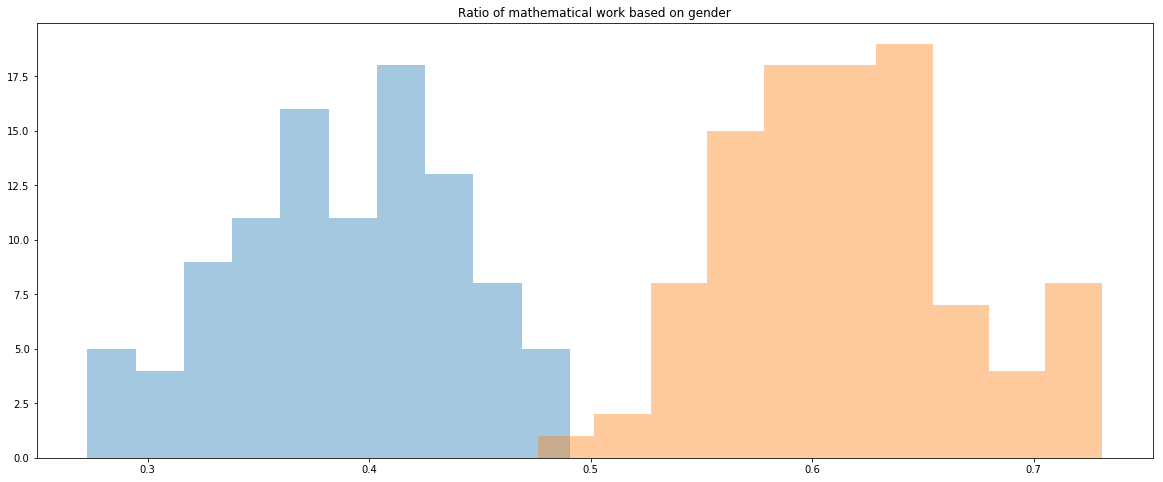

In [43]:
f = plt.figure(figsize=(20,8))
plot1 = f.add_subplot(1, 1, 1)
plot1.hist(all_rations_women, alpha=.4)
plot1.hist(all_rations_men, alpha=.4)
plot1.set_title("Ratio of mathematical work based on gender")

So here, we have presented a couple of possible reasons, why there is not an equal distribution of gender in programming, which has nothing to do with the cultural factors or upbringing. 